In [1]:
import os
import json

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import tf2onnx
import onnx

In [4]:
# tf.config.threading.set_inter_op_parallelism_threads(8) 
# tf.config.threading.set_intra_op_parallelism_threads(8)
# tf.config.set_soft_device_placement(enabled=False)

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

In [6]:
training_set = datagen.flow_from_directory('./Dataset/imagenet_mini/imagenet-mini/train/',
                                           target_size=(224, 224),
                                           seed=666,
                                           batch_size=10,
                                          )

Found 34745 images belonging to 1000 classes.


In [7]:
testing_set = datagen.flow_from_directory('./Dataset/imagenet_mini/imagenet-mini/val/',
                                          target_size=(224, 224),
                                          seed=666,
                                          batch_size=10,
                                          shuffle=False
                                         )

Found 3923 images belonging to 1000 classes.


In [8]:
mobilenet_pretrained = tf.keras.applications.MobileNetV3Large(input_shape=(224, 224, 3), weights='imagenet')

In [9]:
mobilenet_pretrained.summary()

Model: "MobilenetV3large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)            ┃ Output Shape         ┃      Param # ┃ Connected to          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer             │ (None, 224, 224, 3)  │            0 │ -                     │
│ (InputLayer)            │                      │              │                       │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ rescaling (Rescaling)   │ (None, 224, 224, 3)  │            0 │ input_layer[0][0]     │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ conv (Conv2D)           │ (None, 112, 112, 16) │          432 │ rescaling[0][0]       │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ conv_bn                 │ (None, 112, 112, 16) │           64 │ conv[0][0]            │
│ (BatchNormalization)    │                      │              │                       │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ activation (Activation) │ (None, 112, 112, 16) │            0 │ conv_bn[0][0]         │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_depthwise │ (None, 112, 112, 16) │          144 │ activation[0][0]      │
│ (DepthwiseConv2D)       │                      │              │                       │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_depthwis… │ (None, 112, 112, 16) │           64 │ expanded_conv_depthw… │
│ (BatchNormalization)    │                      │              │                       │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ re_lu (ReLU)            │ (None, 112, 112, 16) │            0 │ expanded_conv_depthw… │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_project   │ (None, 112, 112, 16) │          256 │ re_lu[0][0]           │
│ (Conv2D)                │                      │              │                       │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_project_… │ (None, 112, 112, 16) │           64 │ expanded_conv_projec… │
│ (BatchNormalization)    │                      │              │                       │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_add (Add) │ (None, 112, 112, 16) │            0 │ activation[0][0],     │
│                         │                      │              │ expanded_conv_projec… │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_1_expand  │ (None, 112, 112, 64) │        1,024 │ expanded_conv_add[0]… │
│ (Conv2D)                │                      │              │                       │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_1_expand… │ (None, 112, 112, 64) │          256 │ expanded_conv_1_expa… │
│ (BatchNormalization)    │                      │              │                       │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ re_lu_1 (ReLU)          │ (None, 112, 112, 64) │            0 │ expanded_conv_1_expa… │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_1_depthw… │ (None, 113, 113, 64) │            0 │ re_lu_1[0][0]         │
│ (ZeroPadding2D)         │                      │              │                       │
├─────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_1_depthw… │ (None, 56, 56, 64)   │          576 │ expanded_conv_1_dept… │
│ (DepthwiseConv2D)       │             

 Total params: 5,507,432 (21.01 MB)

 Trainable params: 5,483,032 (20.92 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [10]:
# y_pred = mobilenet_pretrained.predict(testing_set, )

In [11]:
mobilenet_model = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), weights=None, dropout_rate=0.8)

In [12]:
initial_learning_rate = 0.1
dropout_rate = 0.8
l2_weight_decay = 1e-5

In [13]:
def lr_scheduler(epoch, lr):
    if epoch % 3 == 0 and epoch != 0:
        return lr * 0.01
    else:
        return lr

In [14]:
mobilenet_model.compile(optimizer=tf.keras.optimizers.RMSprop(momentum=0.9,
                                                              learning_rate=initial_learning_rate,
                                                              weight_decay=l2_weight_decay, ),
                        loss='categorical_crossentropy',
                        metrics=['acc']
                       )

In [15]:
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [16]:
# Exponential Moving Average (EMA)
ema = tf.train.ExponentialMovingAverage(decay=0.9999)
ema.apply(tf.compat.v1.trainable_variables())

In [17]:
for layer in mobilenet_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.momentum = 0.99

In [18]:
history = mobilenet_model.fit(training_set, epochs=20, callbacks=[lr_scheduler_callback], validation_data=testing_set)

Epoch 1/20


C:\Users\Prabesh Lamichhane\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3475/3475 ━━━━━━━━━━━━━━━━━━━━ 631s 177ms/step - acc: 0.0012 - loss: 138.3085 - val_acc: 0.0010 - val_loss: 8.3600 - learning_rate: 0.1000
Epoch 2/20
3475/3475 ━━━━━━━━━━━━━━━━━━━━ 599s 172ms/step - acc: 8.4425e-04 - loss: 8.3148 - val_acc: 7.6472e-04 - val_loss: 8.3250 - learning_rate: 0.1000
Epoch 3/20
3475/3475 ━━━━━━━━━━━━━━━━━━━━ 598s 172ms/step - acc: 0.0011 - loss: 9.1437 - val_acc: 5.0981e-04 - val_loss: 8.3931 - learning_rate: 0.1000
Epoch 4/20
3475/3475 ━━━━━━━━━━━━━━━━━━━━ 699s 201ms/step - acc: 0.0014 - loss: 7.7006 - val_acc: 5.0981e-04 - val_loss: 7.0861 - learning_rate: 0.0010
Epoch 5/20
3475/3475 ━━━━━━━━━━━━━━━━━━━━ 770s 221ms/step - acc: 0.0031 - loss: 7.0223 - val_acc: 0.0023 - val_loss: 7.0998 - learning_rate: 0.0010
Epoch 6/20
3475/3475 ━━━━━━━━━━━━━━━━━━━━ 800s 230ms/step - acc: 0.0026 - loss: 7.0289 - val_acc: 5.0981e-04 - val_loss: 7.0993 - learning_rate: 0.0010
Epoch 7/20
3475/3475 ━━━━━━━━━━━━━━━━━━━━ 710s 204ms/step - acc: 0.0035 - loss: 6.9985 - val_acc: 5.0

In [19]:
history.history.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss', 'learning_rate'])

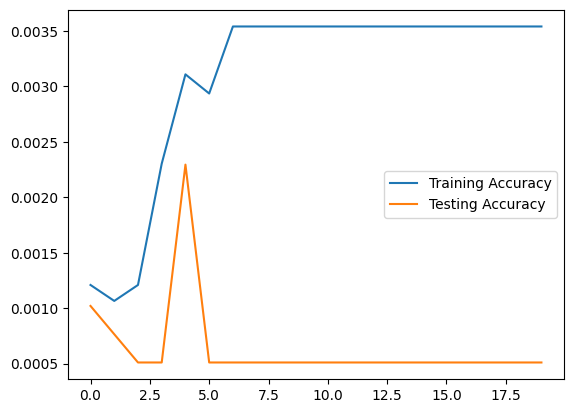

In [22]:
plt.plot(history.history['acc'], label='Training Accuracy',)
plt.plot(history.history['val_acc'], label='Testing Accuracy')
plt.legend()
plt.show()

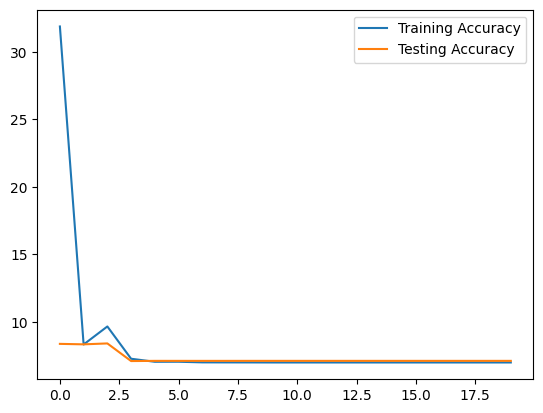

In [23]:
plt.plot(history.history['loss'], label='Training Loss',)
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.legend()
plt.show()

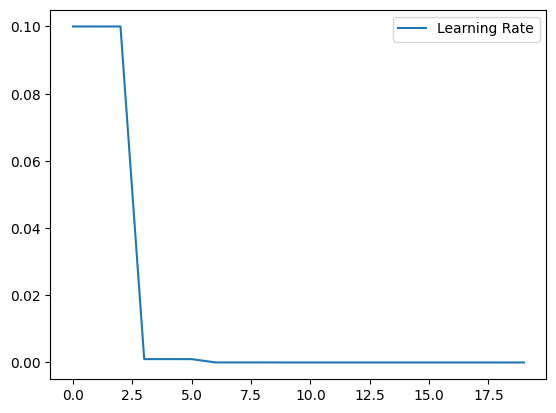

In [24]:
plt.plot(history.history['learning_rate'], label='Learning Rate',)
plt.legend()
plt.show()

In [25]:
mobilenet_model.save('mobilenetV3_Trained.hdf5', )